In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# data preprocessing

gen = pd.read_csv('/content/genetic_disorders.csv')
gen.head()

#drop na
na_count = gen.isna().sum()

gen_clean = gen.dropna()
print(gen_clean.shape)

#before cleaning shape (22083, 45)
#after cleaning shape (5307, 45)

# print(gen_clean.columns)

#has PII and irrelevant data

gen_clean = gen_clean.drop(columns = ['Patient Id', 'Patient First Name', 'Family Name', "Father's name", 'Institute Name', 'Location of Institute', 'Test 1', 'Test 2', 'Test 3', 'Test 4',
       'Test 5', 'Parental consent', 'Place of birth', 'Blood test result',
       'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5' ])

print(gen_clean.columns)

print(gen_clean.isna().sum())


(5307, 45)
Index(['Patient Age', 'Genes in mother's side', 'Inherited from father',
       'Maternal gene', 'Paternal gene', 'Blood cell count (mcL)',
       'Mother's age', 'Father's age', 'Status',
       'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min', 'Follow-up',
       'Gender', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)',
       'Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)',
       'H/O substance abuse', 'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Birth defects',
       'White Blood cell count (thousand per microliter)', 'Genetic Disorder',
       'Disorder Subclass'],
      dtype='object')
Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                      

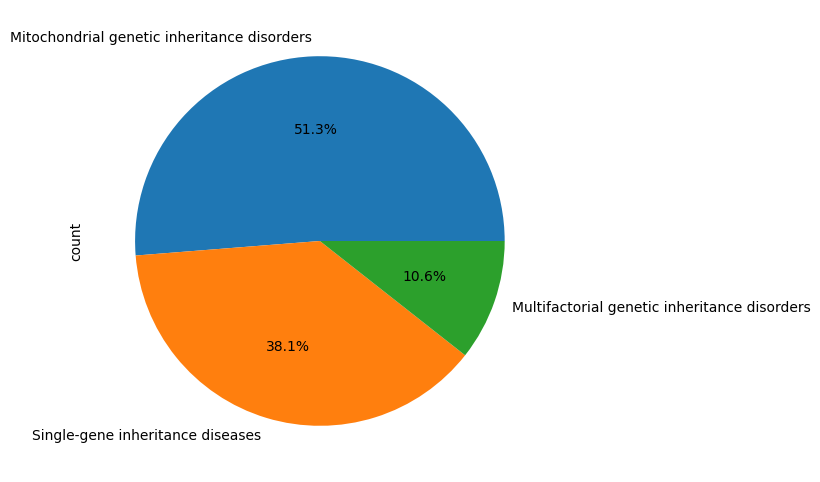

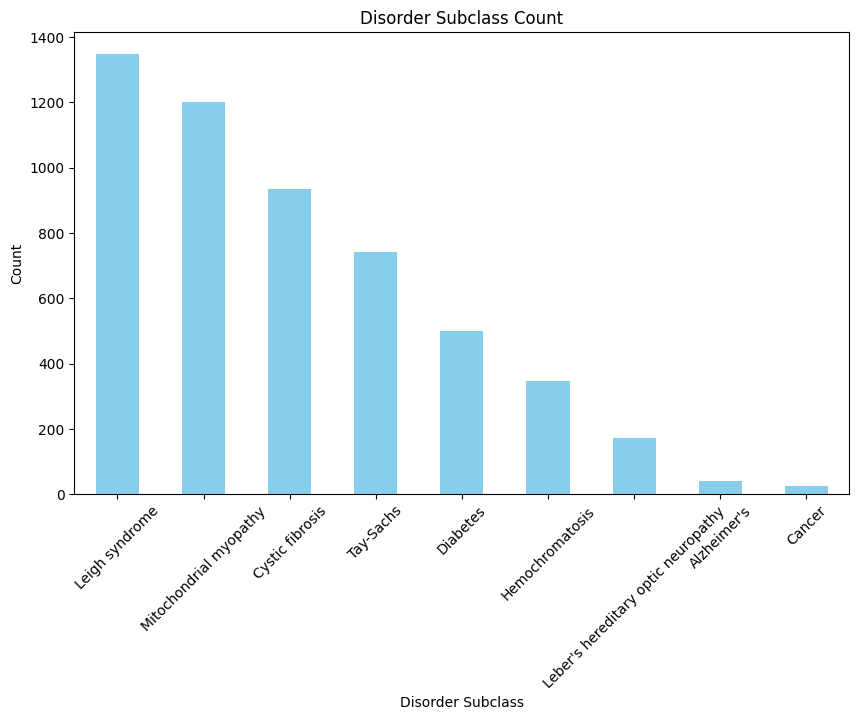

In [ ]:
# data viszualisation

disorder_count = gen_clean['Genetic Disorder'].value_counts()

#plot
disorder_count.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.show()

# plot subclass of disorders
subclass_count = gen_clean['Disorder Subclass'].value_counts()
plt.figure(figsize=(10, 6))
subclass_count.plot(kind= 'bar', width= 0.5, color= 'skyblue')
plt.title('Disorder Subclass Count')
plt.xlabel('Disorder Subclass')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()


Disorder Subclass  Alzheimer's   Cancer  Cystic fibrosis  Diabetes  \
Maternal gene                                                        
No                    0.002583  0.00904          0.13517  0.068876   
Yes                   0.011059  0.00134          0.20811  0.113606   

Disorder Subclass  Hemochromatosis  Leber's hereditary optic neuropathy  \
Maternal gene                                                             
No                        0.092553                             0.017219   
Yes                       0.044571                             0.044236   

Disorder Subclass  Leigh syndrome  Mitochondrial myopathy  Tay-Sachs  
Maternal gene                                                         
No                       0.241498                0.256134   0.176926  
Yes                      0.263405                0.203083   0.110590  
Disorder Subclass  Alzheimer's    Cancer  Cystic fibrosis  Diabetes  \
Paternal gene                                                  

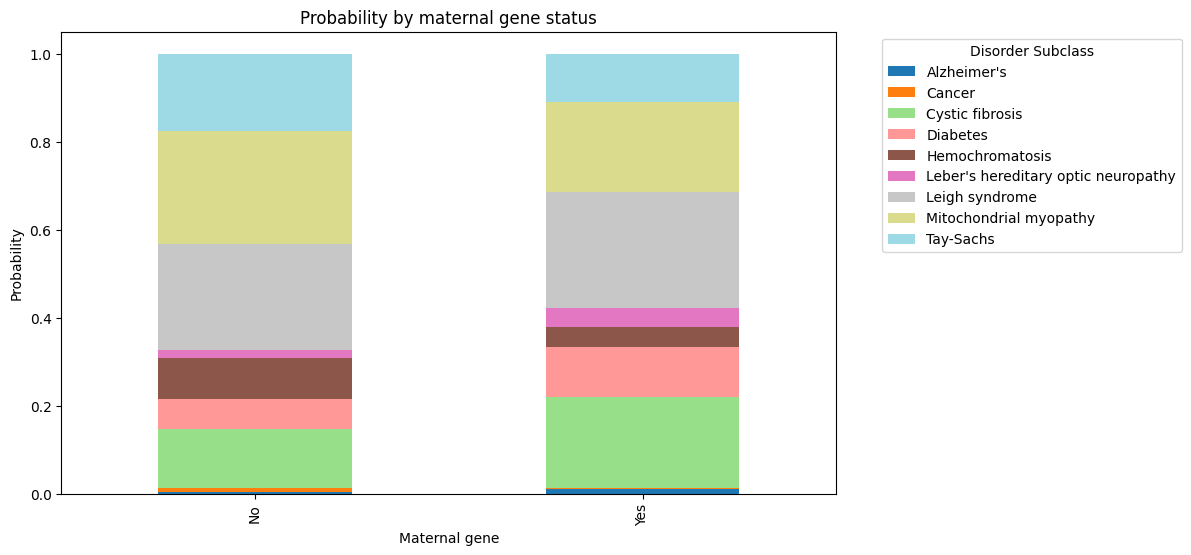

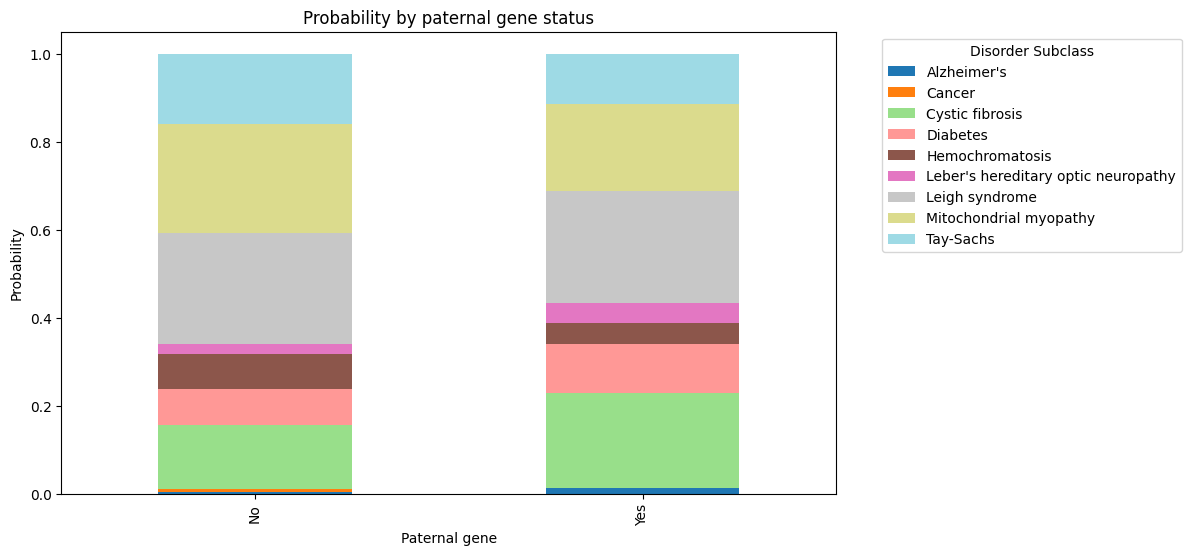

In [ ]:
# Probability - Ruby
#1. Probability of maternal contribution given maternal genes and paternal genes and paternal contribution
#2. Given blood count - probability of hemochromatosis


#probability of a disorder given the maternal gene influence
probability_maternal = gen_clean.groupby('Maternal gene')['Disorder Subclass'].value_counts(normalize=True).unstack()
print(probability_maternal)


#probability of a disorder given paternal gene influence
probability_paternal = gen_clean.groupby('Paternal gene')['Disorder Subclass'].value_counts(normalize=True).unstack()
print(probability_paternal)


#plots
probability_maternal.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='tab20')
plt.title('Probability by maternal gene status')
plt.xlabel('Maternal gene')
plt.ylabel('Probability')
plt.legend(title='Disorder Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

probability_paternal.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='tab20')
plt.title('Probability by paternal gene status')
plt.xlabel('Paternal gene')
plt.ylabel('Probability')
plt.legend(title='Disorder Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# binomial logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# Ensure gen_clean is defined (if you already have it preprocessed)
# Define the dependent variable (binary for mitochondrial disorders)
gen_clean['Mitochondrial Disorder'] = gen_clean['Disorder Subclass'].apply(
    lambda x: 1 if 'Mitochondrial' in str(x) else 0
)

# Define column name for respiratory rate
respiratory_rate_column = 'Respiratory Rate (breaths/min)'

# Check unique values in Respiratory Rate
print("Unique values in Respiratory Rate before cleaning:")
print(gen_clean[respiratory_rate_column].unique())

# Map known string values to numeric respiratory rates
rate_mapping = {
    'Tachypnea': 70,  # Example: high respiratory rate
    'Normal (30-60)': 45  # Midpoint of the range
}

# Apply the mapping to the column
gen_clean[respiratory_rate_column] = gen_clean[respiratory_rate_column].map(rate_mapping)

# Drop rows with NaN in the mapped column (if any other unexpected values exist)
gen_clean = gen_clean.dropna(subset=[respiratory_rate_column])

# Encode 'Maternal gene' as binary (1 for 'Yes', 0 for 'No')
gen_clean['Maternal gene'] = gen_clean['Maternal gene'].apply(lambda x: 1 if x == 'Yes' else 0)

# Independent variables and target variable
X = gen_clean[['Maternal gene', respiratory_rate_column]]
y = gen_clean['Mitochondrial Disorder']

# Ensure predictors are numeric
assert X.applymap(np.isreal).all().all(), "Predictor variables must be numeric."

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = log_reg.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Unique values in Respiratory Rate before cleaning:
['Tachypnea' 'Normal (30-60)']
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87       817
           1       0.00      0.00      0.00       245

    accuracy                           0.77      1062
   macro avg       0.38      0.50      0.43      1062
weighted avg       0.59      0.77      0.67      1062

Accuracy: 0.7693032015065914


<ipython-input-7-262e17ec887e>:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert X.applymap(np.isreal).all().all(), "Predictor variables must be numeric."
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

#Conditional Probability


In [ ]:
gen_clean['Genetic Disorder'].value_counts(normalize=True)

,proportion
Genetic Disorder,
Mitochondrial genetic inheritance disorders,0.512531
Single-gene inheritance diseases,0.381383
Multifactorial genetic inheritance disorders,0.106086


In [ ]:
gen_clean['Respiratory Rate (breaths/min)'].value_counts(normalize=True)

,proportion
Respiratory Rate (breaths/min),
Tachypnea,0.50782
Normal (30-60),0.49218


In [ ]:
respiratory_rate_count = gen_clean['Respiratory Rate (breaths/min)'].value_counts()  # counts of each respiratory rate
total_count = len(gen_clean)
P_respiratory_rate = respiratory_rate_count / total_count

# 2. Calculate joint probabilities (P(Disorder and Respiratory Rate))
joint_probabilities = gen_clean.groupby(['Genetic Disorder', 'Respiratory Rate (breaths/min)']).size() / total_count

# 3. Calculate conditional probabilities P(Disorder | Respiratory Rate)
#  P(Disorder | Respiratory Rate) = P(Disorder and Respiratory Rate) / P(Respiratory Rate)
conditional_probabilities = joint_probabilities / P_respiratory_rate


print("\nConditional probabilities (P(Disorder | Respiratory Rate)):")
print(conditional_probabilities)


Conditional probabilities (P(Disorder | Respiratory Rate)):
Genetic Disorder                              Respiratory Rate (breaths/min)
Mitochondrial genetic inheritance disorders   Normal (30-60)                    0.518377
                                              Tachypnea                         0.506865
Multifactorial genetic inheritance disorders  Normal (30-60)                    0.104135
                                              Tachypnea                         0.107978
Single-gene inheritance diseases              Normal (30-60)                    0.377489
                                              Tachypnea                         0.385158
dtype: float64


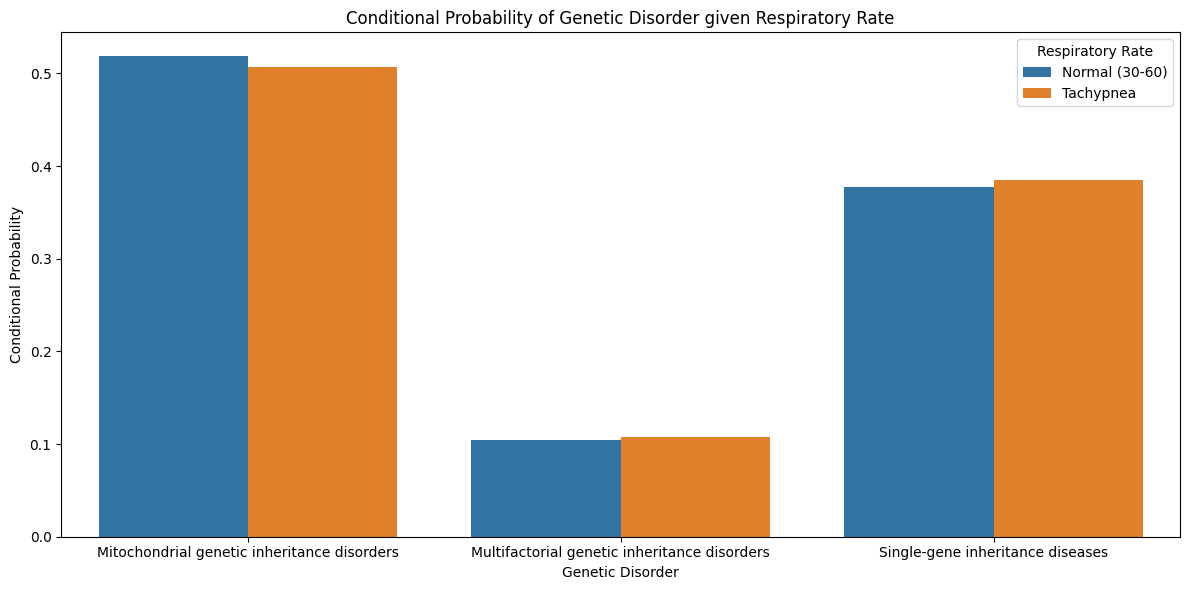

In [ ]:
# Prepare data for visualization
# Create DataFrames for joint and conditional probabilities


data_conditional = {
    'Genetic Disorder': conditional_probabilities.index.get_level_values(0),
    'Respiratory Rate': conditional_probabilities.index.get_level_values(1),
    'Conditional Probability': conditional_probabilities.values
}

# Convert to DataFrame
df_conditional = pd.DataFrame(data_conditional)

# Create subplots for visualizations
fig = plt.figure(figsize=(12, 6))


# Plot conditional probabilities
sns.barplot(x='Genetic Disorder', y='Conditional Probability', hue='Respiratory Rate', data=df_conditional)
plt.title('Conditional Probability of Genetic Disorder given Respiratory Rate')


plt.tight_layout()
plt.show()

##Summary of P(Disorder | Respiratory Rate)




 Mitochondrial genetic inheritance disorders are more likely to be associated with either normal or tachypneic respiratory rates, with a slightly higher chance of occurring with normal respiratory rates.
 Single-gene inheritance diseases show similar trends, but with a slightly stronger association with tachypnea.
 Multifactorial genetic inheritance disorders are less commonly linked with either respiratory state, with only a marginal increase in likelihood for tachypnea compared to normal respiratory rates.
 Tachypnea is generally more common than normal respiratory rates across the genetic disorders studied, particularly in the case of Mitochondrial genetic inheritance disorders and Single-gene inheritance diseases.



In [ ]:
gen_clean['Disorder Subclass'].value_counts(normalize=True)

,proportion
Disorder Subclass,
Leigh syndrome,0.253816
Mitochondrial myopathy,0.226305
Cystic fibrosis,0.176182
Tay-Sachs,0.139627
Diabetes,0.094027
Hemochromatosis,0.065574
Leber's hereditary optic neuropathy,0.032410
Alzheimer's,0.007349
Cancer,0.004711


In [ ]:
gen_clean['H/O radiation exposure (x-ray)'].value_counts()

,count
H/O radiation exposure (x-ray),
No,1382
Not applicable,1354
-,1294
Yes,1277


In [ ]:
# Calculate the probability of each radiation exposure type
radiation_exposure = gen_clean['H/O radiation exposure (x-ray)'].value_counts()  # counts of each radiation exposure type
total_count = len(gen_clean)
P_radiation_exposure = radiation_exposure / total_count  # renaming to reflect correct context

# Calculate joint probabilities (P(Disorder Subclass and Radiation Exposure))
joint_probabilities = gen_clean.groupby(['Disorder Subclass', 'H/O radiation exposure (x-ray)']).size() / total_count

# Calculate conditional probabilities P(Disorder Subclass | Radiation Exposure)
# P(Disorder Subclass | Radiation Exposure) = P(Disorder Subclass and Radiation Exposure) / P(Radiation Exposure)
conditional_probabilities = joint_probabilities / P_radiation_exposure


print("\nConditional probabilities (P(Disorder Subclass | Radiation Exposure)):")
print(conditional_probabilities)



Conditional probabilities (P(Disorder Subclass | Radiation Exposure)):
Disorder Subclass                    H/O radiation exposure (x-ray)
Alzheimer's                          -                                 0.005410
                                     No                                0.008683
                                     Not applicable                    0.003693
                                     Yes                               0.011746
Cancer                               -                                 0.005410
                                     No                                0.003618
                                     Not applicable                    0.006647
                                     Yes                               0.003132
Cystic fibrosis                      -                                 0.170015
                                     No                                0.174385
                                     Not applicable         

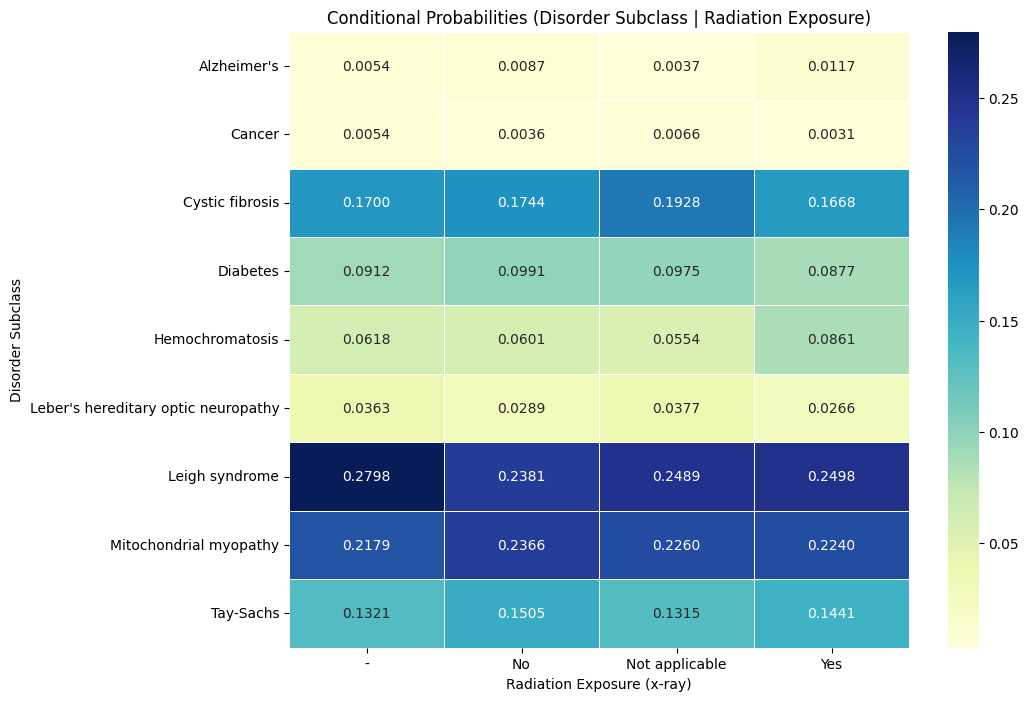

In [ ]:
# Reshape the conditional probabilities to create a pivot table
conditional_heatmap_data = conditional_probabilities.unstack(level='H/O radiation exposure (x-ray)')

# Plot the heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size based on your data
sns.heatmap(conditional_heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=0.5)

# Adding labels and title
plt.title('Conditional Probabilities (Disorder Subclass | Radiation Exposure)')
plt.xlabel('Radiation Exposure (x-ray)')
plt.ylabel('Disorder Subclass')

# Show the plot
plt.show()

#Not applicable - not relevant
# - Missing


##Casual Inference

##a causal road map

1. specify a scientific question: whether maternal gene indicators have a stronger causal link to certain disorders (mitochondria myopathy) than paternal indicators

2. specify a casual model representing scientific knowledge (DAGs and casual models)

3.specify casual question and casual parameter (counterfactual questions)
4. specify observed data and link to casual model (identification)
5. Estimate the chosen parameter
6. interpret results.


##Specify a Causal Model (DAG)

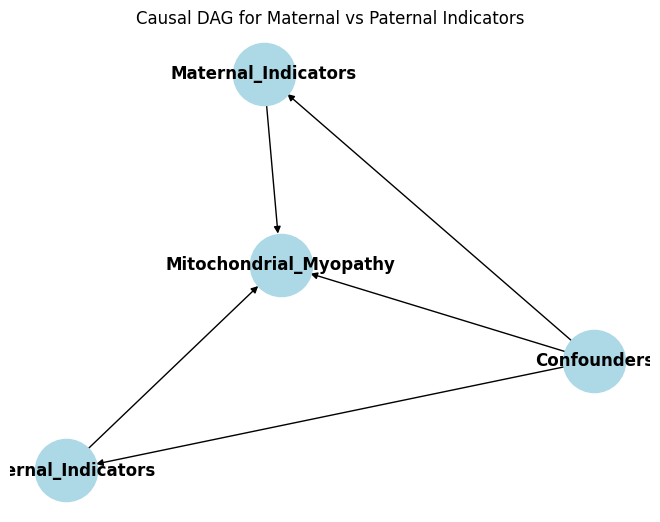

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the DAG
dag = nx.DiGraph()
dag.add_edges_from([
    ("Maternal_Indicators", "Mitochondrial_Myopathy"),
    ("Paternal_Indicators", "Mitochondrial_Myopathy"),
    ("Confounders", "Maternal_Indicators"),
    ("Confounders", "Paternal_Indicators"),
    ("Confounders", "Mitochondrial_Myopathy")
])

# Draw the DAG
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=12, font_weight="bold")
plt.title("Causal DAG for Maternal vs Paternal Indicators")
plt.show()


##Specify Causal Question and Parameter (Counterfactuals)

 compute the Average Treatment Effect (ATE) or Conditional Average Treatment Effect (CATE) to quantify the causal impact of maternal and paternal indicators on mitochondrial myopathy. This involves defining and estimating two potential outcomes:


 Y1 : The outcome (e.g., mitochondrial myopathy) when the maternal or paternal indicator is present.

 Y0 : The outcome when the maternal or paternal indicator is absent.
The causal effect is then calculated as the difference between these two outcomes:

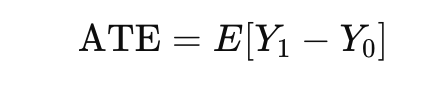

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from sklearn.utils import resample


In [ ]:
import pandas as pd

# Load the dataset
gen = pd.read_csv('/content/genetic_disorders.csv')

# Initial exploration
print(f"Initial dataset shape: {gen.shape}")
print("Initial columns:", gen.columns)

# Step 1: Drop rows with missing values
gen_clean = gen.dropna()
print(f"Shape after dropping rows with missing values: {gen_clean.shape}")

# Step 2: Drop irrelevant columns
irrelevant_columns = [
    'Patient Id', 'Patient First Name', 'Family Name', "Father's name",
    'Institute Name', 'Location of Institute', 'Test 1', 'Test 2', 'Test 3',
    'Test 4', 'Test 5', 'Parental consent', 'Place of birth', 'Blood test result',
    'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'
]
gen_clean = gen_clean.drop(columns=irrelevant_columns)

# Step 3: Verify cleaned data
print(f"Remaining columns: {gen_clean.columns}")
print(f"Remaining dataset shape: {gen_clean.shape}")
print("Missing values after cleaning:")
print(gen_clean.isna().sum())


Initial dataset shape: (22083, 45)
Initial columns: Index(['Patient Id', 'Patient Age', 'Genes in mother's side',
       'Inherited from father', 'Maternal gene', 'Paternal gene',
       'Blood cell count (mcL)', 'Patient First Name', 'Family Name',
       'Father's name', 'Mother's age', 'Father's age', 'Institute Name',
       'Location of Institute', 'Status', 'Respiratory Rate (breaths/min)',
       'Heart Rate (rates/min', 'Test 1', 'Test 2', 'Test 3', 'Test 4',
       'Test 5', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)', 'Place of birth',
       'Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)',
       'H/O substance abuse', 'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Birth defects',
       'White Blood cell count (thousand per microliter)', 'Blood test result',
       'S

Change categorial data to numeric data and continue the work flow

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Step 1: Encode categorical confounders
# List of categorical columns
categorical_columns = ['Gender', 'Birth asphyxia']

# Use one-hot encoding for categorical confounders, using gen instead of data
encoded_confounders = pd.get_dummies(gen[categorical_columns], drop_first=True)

# Combine encoded confounders with numeric ones
numeric_confounders = [
    'Patient Age', 'Blood cell count (mcL)', "Mother's age", "Father's age",
    'H/O serious maternal illness', 'H/O substance abuse',
    'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies',
    'No. of previous abortion'
]

# Select the listed confounders
confounder_columns = [
    'Patient Age', 'Blood cell count (mcL)', "Mother's age", "Father's age",
    'H/O serious maternal illness', 'H/O substance abuse',
    'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies',
    'No. of previous abortion'
]

# Filter non-numeric columns, using gen instead of data
non_numeric_columns = gen[confounder_columns].select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

print("Data types after conversion:")
print(gen[confounder_columns].dtypes)

# Map binary strings to numeric (e.g., 'Yes' -> 1, 'No' -> 0)
binary_columns = ['H/O serious maternal illness', 'H/O substance abuse',
                  'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies']

for col in binary_columns:
    # using gen instead of data
    gen[col] = gen[col].map({'Yes': 1, 'No': 0, 'Not available': None, '-': None})

# Convert categorical columns to one-hot encoding (if needed), using gen instead of data
categorical_columns = non_numeric_columns.difference(binary_columns)
gen = pd.get_dummies(gen, columns=categorical_columns, drop_first=True)


# Filter non-numeric columns, using gen instead of data
non_numeric_columns = gen[confounder_columns].select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

print("Data types after conversion:")
print(gen[confounder_columns].dtypes)

# Check for remaining non-numeric values, using gen instead of data
print("Remaining non-numeric values:")
for col in confounder_columns:
    print(f"{col}: {gen[col].unique()}")

print("Data types after conversion:")
print(gen[confounder_columns].dtypes)

# Check for remaining non-numeric values, using gen instead of data
print("Remaining non-numeric values:")
for col in confounder_columns:
    print(f"{col}: {gen[col].unique()}")



# using gen instead of data
confounders_df = pd.concat([gen[numeric_confounders], encoded_confounders], axis=1)

# Step 2: Update propensity_score_matching function to accept the processed confounders
def propensity_score_matching(data, treatment_col, outcome_col, confounders_df):
    """
    Compute the Average Treatment Effect (ATE) using Propensity Score Matching (PSM).
    """
    model = LogisticRegression(max_iter=1000)
    T = data[treatment_col]
    model.fit(confounders_df, T)
    data['propensity_score'] = model.predict_proba(confounders_df)[:, 1]

    treated = data[data[treatment_col] == 1]
    control = data

Non-numeric columns: Index(['H/O serious maternal illness', 'H/O substance abuse',
       'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies'],
      dtype='object')
Data types after conversion:
Patient Age                                     float64
Blood cell count (mcL)                          float64
Mother's age                                    float64
Father's age                                    float64
H/O serious maternal illness                     object
H/O substance abuse                              object
Assisted conception IVF/ART                      object
History of anomalies in previous pregnancies     object
No. of previous abortion                        float64
dtype: object
Non-numeric columns: Index([], dtype='object')
Data types after conversion:
Patient Age                                     float64
Blood cell count (mcL)                          float64
Mother's age                                    float64
Father's a

In [ ]:
# Drop rows with missing values from the confounders DataFrame and the main dataset
confounders_df = confounders_df.dropna()
gen_clean = gen.dropna()

# Ensure confounders_df and gen_clean are aligned after dropping rows
confounders_df = confounders_df.loc[gen_clean.index]

# Verify there are no missing values
print("Missing values after dropping rows:")
print(confounders_df.isna().sum())
print(gen_clean.isna().sum())


Missing values after dropping rows:
Patient Age                                     0
Blood cell count (mcL)                          0
Mother's age                                    0
Father's age                                    0
H/O serious maternal illness                    0
H/O substance abuse                             0
Assisted conception IVF/ART                     0
History of anomalies in previous pregnancies    0
No. of previous abortion                        0
Gender_Female                                   0
Gender_Male                                     0
Birth asphyxia_No record                        0
Birth asphyxia_Not available                    0
Birth asphyxia_Yes                              0
dtype: int64
Patient Id                                          0
Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                      

In [ ]:
# Ensure treatment and outcome columns are numeric
gen_clean['maternal_gene_binary'] = gen_clean['Maternal gene'].map({'Yes': 1, 'No': 0})
gen_clean['paternal_gene_binary'] = gen_clean['Paternal gene'].map({'Yes': 1, 'No': 0})
gen_clean['mitochondrial_myopathy'] = gen_clean['Disorder Subclass'].str.contains('mitochondrial', case=False, na=False).astype(int)

# Propensity Score Matching Function
def propensity_score_matching(data, treatment_col, outcome_col, confounders_df):
    """
    Compute the Average Treatment Effect (ATE) using Propensity Score Matching (PSM).
    """
    model = LogisticRegression(max_iter=1000)
    T = data[treatment_col]
    model.fit(confounders_df, T)
    data['propensity_score'] = model.predict_proba(confounders_df)[:, 1]

    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    distances = pairwise_distances(treated[['propensity_score']], control[['propensity_score']])
    closest_indices = np.argmin(distances, axis=1)
    matched_control = control.iloc[closest_indices]

    treated_outcomes = treated[outcome_col].values
    control_outcomes = matched_control[outcome_col].values
    ate = np.mean(treated_outcomes - control_outcomes)
    return ate

# Estimate ATE for Maternal and Paternal genes
maternal_ate = propensity_score_matching(gen_clean, 'maternal_gene_binary', 'mitochondrial_myopathy', confounders_df)
paternal_ate = propensity_score_matching(gen_clean, 'paternal_gene_binary', 'mitochondrial_myopathy', confounders_df)

# Compare results
print(f"ATE for Maternal gene: {maternal_ate}")
print(f"ATE for Paternal gene: {paternal_ate}")

if maternal_ate > paternal_ate:
    print("Maternal gene has a stronger causal link to mitochondrial myopathy.")
else:
    print("Paternal gene has a stronger causal link to mitochondrial myopathy.")


<ipython-input-7-211e5b1f13ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_clean['maternal_gene_binary'] = gen_clean['Maternal gene'].map({'Yes': 1, 'No': 0})
<ipython-input-7-211e5b1f13ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_clean['paternal_gene_binary'] = gen_clean['Paternal gene'].map({'Yes': 1, 'No': 0})
<ipython-input-7-211e5b1f13ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

ATE for Maternal gene: -0.03581081081081081
ATE for Paternal gene: -0.05668358714043993
Maternal gene has a stronger causal link to mitochondrial myopathy.


<ipython-input-7-211e5b1f13ea>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['propensity_score'] = model.predict_proba(confounders_df)[:, 1]


Propensity Score Matching balances the treatment and control groups to reduce bias from confounders.
It estimates the causal effect of the treatment by comparing outcomes between matched individuals.
It is a powerful tool for causal inference in non-experimental settings, like the analysis of maternal and paternal genes.

ATE Results:
ATE for Maternal Gene: -0.0358
ATE for Paternal Gene: -0.0567
Interpretation:
Both maternal and paternal genes show a negative ATE, meaning that the presence of these genes is associated with a slightly decreased probability of mitochondrial myopathy.
The effect of the maternal gene is stronger (closer to 0) compared to the paternal gene in absolute magnitude.

##Bar Chart to Compare ATEs

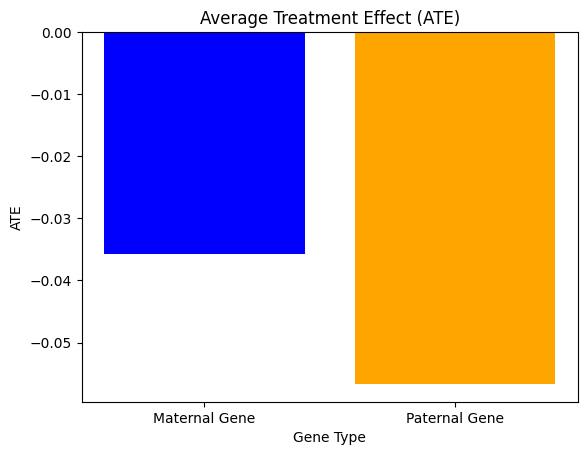

In [ ]:
import matplotlib.pyplot as plt

ates = [-0.0358, -0.0567]
labels = ['Maternal Gene', 'Paternal Gene']

plt.bar(labels, ates, color=['blue', 'orange'])
plt.title('Average Treatment Effect (ATE)')
plt.ylabel('ATE')
plt.xlabel('Gene Type')
plt.show()


##Confounder Balance Check

In [ ]:
# Verify the columns in confounders_df
print("Columns in confounders_df:", confounders_df.columns)

# Updated balance check function
def confounder_balance_check(data, treatment_col, confounders_df):
    """
    Check balance of confounders before and after matching.
    Dynamically handles all columns in confounders_df.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    print(f"Balance Check for {treatment_col}:")
    for col in confounders_df.columns:  # Dynamically loop through all columns in confounders_df
        treated_mean = treated[col].mean() if col in treated.columns else 0
        control_mean = control[col].mean() if col in control.columns else 0
        print(f"{col}: Treated Mean = {treated_mean:.3f}, Control Mean = {control_mean:.3f}, Difference = {abs(treated_mean - control_mean):.3f}")

# Perform the balance check again
print("Before Matching:")
confounder_balance_check(gen_clean, 'maternal_gene_binary', confounders_df)
confounder_balance_check(gen_clean, 'paternal_gene_binary', confounders_df)


Columns in confounders_df: Index(['Patient Age', 'Blood cell count (mcL)', 'Mother's age', 'Father's age',
       'H/O serious maternal illness', 'H/O substance abuse',
       'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Gender_Ambiguous', 'Gender_Female',
       'Gender_Male', 'Birth_asphyxia_No record',
       'Birth_asphyxia_Not available', 'Birth_asphyxia_Yes'],
      dtype='object')
Before Matching:
Balance Check for maternal_gene_binary:
Patient Age: Treated Mean = 6.859, Control Mean = 7.044, Difference = 0.185
Blood cell count (mcL): Treated Mean = 4.902, Control Mean = 4.906, Difference = 0.004
Mother's age: Treated Mean = 34.714, Control Mean = 34.716, Difference = 0.003
Father's age: Treated Mean = 41.468, Control Mean = 42.319, Difference = 0.852
H/O serious maternal illness: Treated Mean = 0.494, Control Mean = 0.494, Difference = 0.000
H/O substance abuse: Treated Mean = 0.507, Control Mean = 0.5

In [ ]:
def propensity_score_matching(data, treatment_col, outcome_col, confounders_df):
    """
    Perform Propensity Score Matching (PSM) and return matched data and ATE.
    """
    model = LogisticRegression(max_iter=1000)
    T = data[treatment_col]
    model.fit(confounders_df, T)
    data['propensity_score'] = model.predict_proba(confounders_df)[:, 1]

    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    distances = pairwise_distances(treated[['propensity_score']], control[['propensity_score']])
    closest_indices = np.argmin(distances, axis=1)
    matched_control = control.iloc[closest_indices]

    # Combine treated and matched control into one DataFrame
    matched_data = pd.concat([treated, matched_control], axis=0)

    # Calculate the ATE
    treated_outcomes = treated[outcome_col].values
    control_outcomes = matched_control[outcome_col].values
    ate = np.mean(treated_outcomes - control_outcomes)

    return matched_data, ate


In [ ]:
matched_data_maternal, maternal_ate = propensity_score_matching(
    gen_clean, 'maternal_gene_binary', 'mitochondrial_myopathy', confounders_df
)
matched_data_paternal, paternal_ate = propensity_score_matching(
    gen_clean, 'paternal_gene_binary', 'mitochondrial_myopathy', confounders_df
)


<ipython-input-17-dddb30c8ae90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['propensity_score'] = model.predict_proba(confounders_df)[:, 1]
<ipython-input-17-dddb30c8ae90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['propensity_score'] = model.predict_proba(confounders_df)[:, 1]


In [ ]:
print("After Matching for Maternal Gene:")
confounder_balance_check(matched_data_maternal, 'maternal_gene_binary', confounders_df)

print("After Matching for Paternal Gene:")
confounder_balance_check(matched_data_paternal, 'paternal_gene_binary', confounders_df)


After Matching for Maternal Gene:
Balance Check for maternal_gene_binary:
Patient Age: Treated Mean = 6.859, Control Mean = 6.933, Difference = 0.074
Blood cell count (mcL): Treated Mean = 4.902, Control Mean = 4.893, Difference = 0.008
Mother's age: Treated Mean = 34.714, Control Mean = 35.043, Difference = 0.329
Father's age: Treated Mean = 41.468, Control Mean = 41.340, Difference = 0.128
H/O serious maternal illness: Treated Mean = 0.494, Control Mean = 0.508, Difference = 0.014
H/O substance abuse: Treated Mean = 0.507, Control Mean = 0.497, Difference = 0.009
Assisted conception IVF/ART: Treated Mean = 0.512, Control Mean = 0.503, Difference = 0.009
History of anomalies in previous pregnancies: Treated Mean = 0.520, Control Mean = 0.510, Difference = 0.010
No. of previous abortion: Treated Mean = 1.972, Control Mean = 1.993, Difference = 0.021
Gender_Ambiguous: Treated Mean = 0.000, Control Mean = 0.000, Difference = 0.000
Gender_Female: Treated Mean = 0.000, Control Mean = 0.000

In [ ]:
print(f"ATE for Maternal gene: {maternal_ate}")
print(f"ATE for Paternal gene: {paternal_ate}")


ATE for Maternal gene: -0.03986486486486487
ATE for Paternal gene: -0.06175972927241963
